<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predciction-with-Cosin-Similarity" data-toc-modified-id="Predciction-with-Cosin-Similarity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predciction with Cosin Similarity</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Visualizing" data-toc-modified-id="Visualizing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing</a></span></li><li><span><a href="#학습" data-toc-modified-id="학습-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>학습</a></span></li></ul></div>

## Predciction with Cosin Similarity
Sentence들을 벡터화 시키면 유사도를 확인할 수 있습니다. 이러한 방법으로,
* 모든 가능한 벡터들의 조합 각각의 평균을 구하여 서로 Cosine Similarity를 구하고 최대 값을 해당 레이블로 선정합니다.

In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import glob
import functools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.decomposition import PCA
rdm_seed = 29
np.random.seed(rdm_seed)
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import keras.optimizers

Using TensorFlow backend.


## Modeling
3번 설계와 같습니다

In [4]:
mydata_train = pd.read_csv('./Data/Prepossed/Prepossed_data_train.csv')
mydata_test = pd.read_csv('./Data/Prepossed/Prepossed_data_test.csv')
mydata =  pd.read_csv('./Data/Prepossed/Prepossed_data.csv')
mydata = mydata.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
mydata_train = mydata_train.drop([ 'Unnamed: 0.1'],axis = 1)
mydata_test = mydata_test.drop([ 'Unnamed: 0.1'],axis = 1)

train_X, train_y = mydata_train['Plot'], mydata_train.drop(['BID', 'Plot'], axis=1)
test_X, test_y = mydata_test['Plot'], mydata_test.drop(['BID', 'Plot'], axis=1)

category_columns = train_y.columns

In [5]:
train_vector = np.load("./Data/np/train_Plot.npy", allow_pickle=True)
test_vector = np.load("./Data/np/test_Plot.npy", allow_pickle=True)

In [6]:
# Creating a LUT for the 1505 labels
train_y_labels= train_y.groupby(list(category_columns)).ngroup()
y_labels_lut = train_y.copy(deep=True) 
y_labels_lut['Labels'] = train_y_labels
y_labels_lut = y_labels_lut.drop_duplicates()
y_labels_lut = y_labels_lut.reset_index(drop=True).set_index('Labels').sort_index()


# One-hot encoding the output labels
num_classes = y_labels_lut.shape[0]
train_y_onehot = np_utils.to_categorical(train_y_labels, num_classes = num_classes)

## Visualizing
벡터 유사도를 눈으로 확인하기 위한 함수들입니다.

**HeatMap Visualization**

**PCA 2D Representation Visuaization**
- 3개의 레이블에 대하여 첫 50개의 데이터를 그림으로 작성
- Correlation이 높은 방법들에 대하여 plot데이터가 유사할 것으로 예상

In [7]:
def plot_similarity(labels, features, rotation):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=rotation)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


def run_and_plot(messages_, labels):
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    similarity_message_encodings = embed(similarity_input_placeholder)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())  
        message_embeddings_ = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: messages_})
        plot_similarity(labels, message_embeddings_, 90)

In [8]:
def get_2d_representation(words_list, labels):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        tmp = {}
        label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
        unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
        df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
        colors = ['r', 'b', 'g', 'm', 'k']
        
        fig, ax = plt.subplots(figsize=(10,10)) 
        for idx in range(len(set(labels))):
            ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])
        
        ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
        ax.legend()

In [9]:
def movie_genre_heatmap(features, labels):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=90)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))

In [10]:
def movie_genre_scatter_plot(movie_plot_vectors, labels):
    model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
    # Apply the fit_transform method of model to grains: pca_features
    pca_features = model.fit_transform(movie_plot_vectors) # Transforms embeddings to vectors of size 2
    # Assign 0th column of pca_features: xs
    xs = pca_features[:,0] #The first component of PCA
    # Assign 1st column of pca_features: ys
    ys = pca_features[:,1] #Second component of PCA

    #Next, we'll plot these results
    tmp = {}
    label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
    colors = ['r', 'b', 'g', 'm', 'k']

    fig, ax = plt.subplots(figsize=(10,10)) 
    for idx in range(len(set(labels))):
        ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])

    ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
    ax.legend()

In [11]:
train_y.head(1)

,math,dp,implementation,greedy,data structures,sortings,dfs,graphs,trees,constructive algorithms,brute force,strings,binary search,number theory,geometry
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


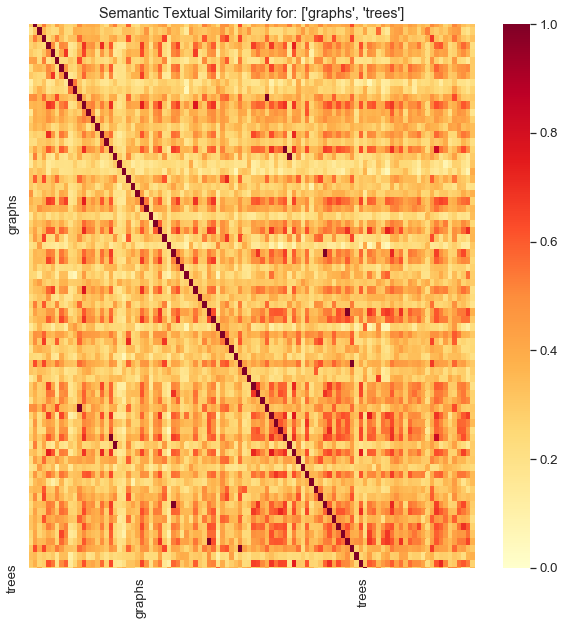

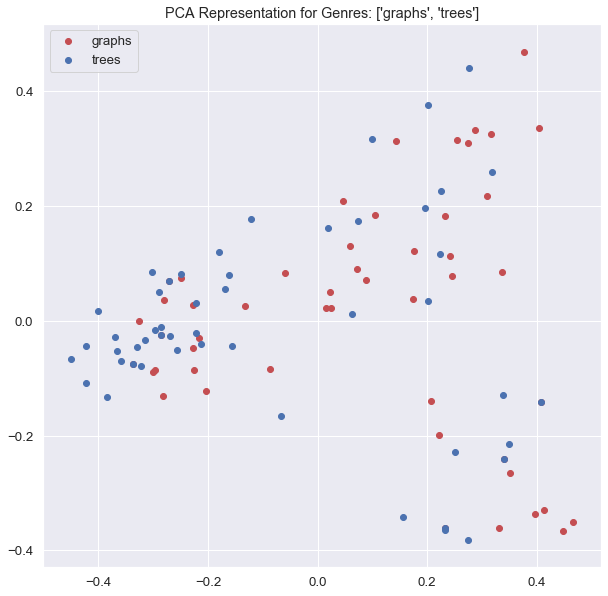

In [14]:

genre_list = ['graphs', 'trees']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

## 학습

In [36]:
def cosine(s1, s2):
  #"""Take two pd.Series objects and return their cosine similarity."""
  return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

def max_cosine(vector, label_embedding):
    '''
  Function returns the label_embedding index with maximum cosine 
  similarity with the input vector 
  '''
    max_idx, max_cosine_sim = -1, float('-inf')
    if vector['index']%1000==0:
        print('Processing plot idx {0}'.format(vector['index']))
    for idx in range(label_embedding.shape[0]):
        curr_sim = cosine(vector[1:], label_embedding.iloc[idx,:])
        (max_idx, max_cosine_sim) = (idx, curr_sim) if curr_sim>max_cosine_sim else (max_idx, max_cosine_sim)
    return pd.Series([max_idx, max_cosine_sim])

def max_cosine_unit_test(vector, label_embedding):
  
    cosine_list = []
    for idx in range(label_embedding.shape[0]):
        cosine_list.append(cosine(vector, label_embedding.iloc[idx,:]))
    return cosine_list

In [37]:
train_y_labels= train_y.groupby(list(category_columns)).ngroup()
y_labels_lut = train_y.copy(deep=True) 
y_labels_lut['Labels'] = train_y_labels
y_labels_lut = y_labels_lut.drop_duplicates()
y_labels_lut = y_labels_lut.reset_index(drop=True).set_index('Labels').sort_index()

# Getting the embedding vectors for each of the unique 1505 labels
train_vector_df = pd.DataFrame(train_vector)
train_vector_df['Labels'] = train_y_labels
label_embedding = train_vector_df.groupby('Labels').mean()

# Converting the vectors into dataframe so that we can use the apply method
test_vector_df = pd.DataFrame(test_vector)
test_vector_df = test_vector_df.reset_index()

In [38]:
%%time
y_pred_df = test_vector_df.apply(max_cosine, label_embedding=label_embedding, axis=1)


Processing plot idx 0.0
Processing plot idx 0.0
Wall time: 8min 41s


In [40]:
from helper_functions import *

predictions = pd.merge(y_pred_df, y_labels_lut, how='left', left_on=0, right_on='Labels')[category_columns]
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
math,0.42,0.39,0.40,251.0
dp,0.26,0.31,0.28,193.0
implementation,0.35,0.32,0.33,267.0
greedy,0.34,0.28,0.30,248.0
data structures,0.27,0.35,0.31,158.0
sortings,0.18,0.21,0.19,96.0
dfs,0.26,0.31,0.28,93.0
graphs,0.40,0.53,0.45,104.0
trees,0.59,0.71,0.64,92.0
constructive algorithms,0.24,0.24,0.24,133.0
